In [123]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [124]:
df = pd.read_csv("/neurospin/dico/data/deep_folding/current/models/Champollion_V0/UKB-RAP/all_regions.csv")
df.head()

,region,p,side
0,SPoC_left,0.000511,left
1,STsbr_right,0.009886,right
2,SC-SPoC_left,0.000023,left
3,FCLp-SGSM_right,0.000178,right
4,STsbr_right,0.529594,right


In [125]:
df

,region,p,side
0,SPoC_left,0.000511,left
1,STsbr_right,0.009886,right
2,SC-SPoC_left,0.000023,left
3,FCLp-SGSM_right,0.000178,right
4,STsbr_right,0.529594,right
...,...,...,...
95,SFinf-BROCA-SPeCinf_left,0.153614,left
96,SsP-SPaint_left,0.000692,left
97,OCCIPITAL_right,0.005336,right
98,SPeC_right,0.053186,right


In [126]:
df["p"] = -np.log10(df["p"])

In [127]:
df.head()

,region,p,side
0,SPoC_left,3.291979,left
1,STsbr_right,2.004995,right
2,SC-SPoC_left,4.641480,left
3,FCLp-SGSM_right,3.748429,right
4,STsbr_right,0.276057,right


In [128]:
df = df.groupby(["region", "side"]).mean()

In [129]:
def plot_horizontal(res, region_name, ax, p_value, title):
    labelsize=12
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=p_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    # ax.axvline(x=-np.log10(0.05), color='black', linestyle='-')
    ax.axvline(x=-np.log10(0.05/56), color='red', linestyle='-')
    # ax.barh(res[region_name], res[f2_value], fill=True, color='lightgray')
    ax.errorbar(res[p_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    ax.set_xlim((0, 9.0))
    ax.set_xlabel("-log$_{10}$(p)")
    ax.set_title(title)


In [130]:
df = df.sort_values(by="p", ascending=True).reset_index()
df.head()

,region,side,p
0,STs-SGSM_left,left,0.474858
1,SFmedian-SFpoltr-SFsup_right,right,0.631705
2,SFmarginal-SFinfant_left,left,0.696752
3,SFinter-SFsup_left,left,0.747669
4,SFinf-BROCA-SPeCinf_left,left,0.813570


In [131]:
exclude = ["fronto-parietal_medial_face_left", "fronto-parietal_medial_face_right",
            "FCLp-SGSM_left", "FCLp-SGSM_right", "STs-SGSM_left", "STs-SGSM_right"]
df = df[~df["region"].isin(exclude)]
df.head()

,region,side,p
1,SFmedian-SFpoltr-SFsup_right,right,0.631705
2,SFmarginal-SFinfant_left,left,0.696752
3,SFinter-SFsup_left,left,0.747669
4,SFinf-BROCA-SPeCinf_left,left,0.813570
5,CINGULATE_left,left,0.956018


In [132]:
dic = {
    "FCLp-subsc-FCLa-INSULA": "F.C.L.p.-subsc.-F.C.L.a.-INSULA.",
    "FCMpost-SpC": "F.C.M.post.-S.p.C.",
    "FColl-SRh": "F.Coll.-S.Rh.",
    "FIP": "F.I.P.",
    "FPO-SCu-ScCal": "F.P.O.-S.Cu.-Sc.Cal.",
    "Lobule_parietal_sup": "Lobule_parietal_sup.",
    "ORBITAL": "S.Or.",
    "SC-SPeC": "S.C.-S.Pe.C.",
    "SC-SPoC": "S.C.-S.Po.C.",
    "SC-sylv": "S.C.-sylv.",
    "SFinf-BROCA-SPeCinf": "S.F.inf.-BROCA-S.Pe.C.inf.",
    "SFint-FCMant": "S.F.int.-F.C.M.ant.",
    "SFint-SR": "S.F.int.-S.R.",
    "SFinter-SFsup": "S.F.inter.-S.F.sup.",
    "SFmarginal-SFinfant":"S.F.marginal-S.F.inf.ant.",
    "SFmedian-SFpoltr-SFsup": "S.F.median-S.F.pol.tr.-S.F.sup.",
    "SOr-SOlf": "S.Or.-S.Olf.",
    "SPeC": "S.Pe.C.",
    "SPoC": "S.Po.C.",
    "STi-SOTlat": "S.T.i.-S.O.T.lat.",
    "STi-STs-STpol": "S.T.i.-S.T.s.-S.T.pol.",
    "STsbr": "S.T.s.br.",
    "STs": "S.T.s.",
    "ScCal-SLi": "Sc.Cal.-S.Li.",
    "SsP-SPaint": "S.s.P.-S.Pa.int.",
}

In [133]:
for key in dic.keys():
    df["region"] = df["region"].str.replace(key, dic[key])
df.head()

,region,side,p
1,S.F.median-S.F.pol.tr.-S.F.sup._right,right,0.631705
2,S.F.marginal-S.F.inf.ant._left,left,0.696752
3,S.F.inter.-S.F.sup._left,left,0.747669
4,S.F.inf.-BROCA-S.Pe.C.inf._left,left,0.813570
5,CINGULATE_left,left,0.956018


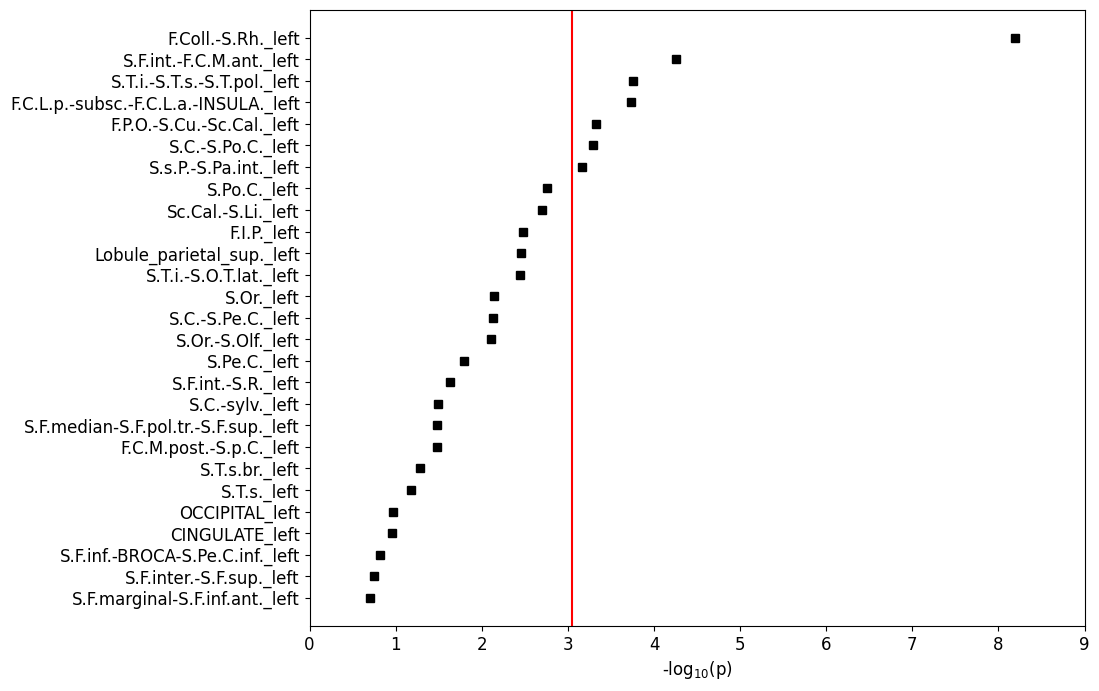

In [134]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_horizontal(df[df.side=='left'], "region", ax, "p", "")
plt.show()

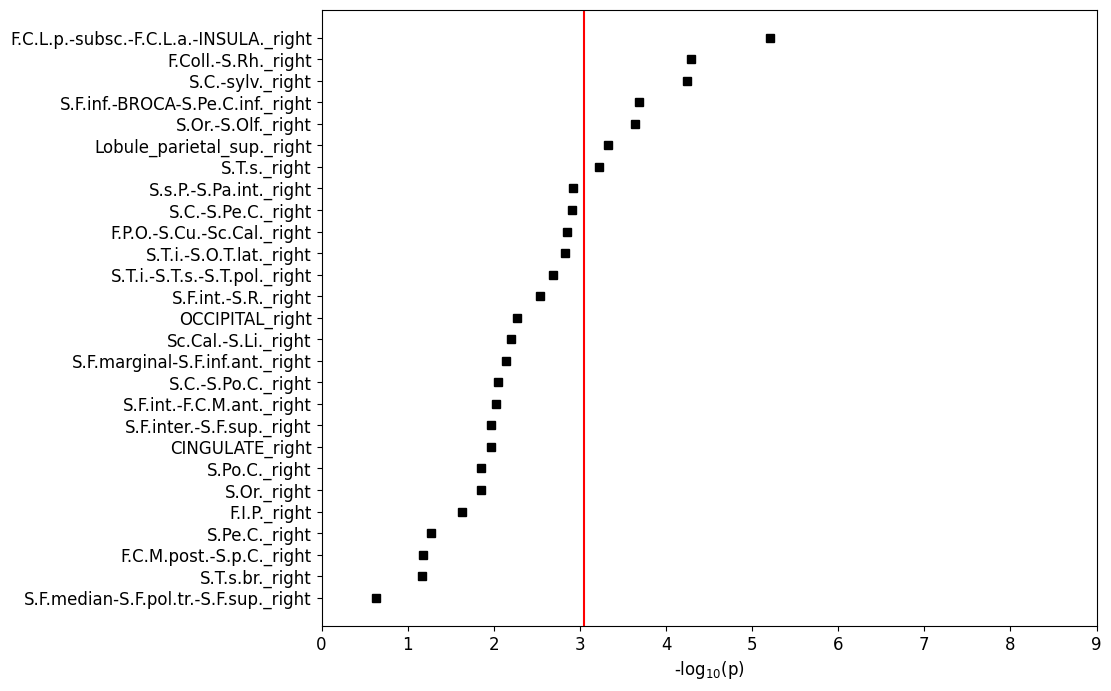

In [135]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_horizontal(df[df.side=='right'], "region", ax, "p", "")
plt.show()

In [112]:
# df.to_csv(output_filename)